In [1]:
from ope_methods.model_based import F110ModelBased
from ope_methods.dataset import F110Dataset, F110DatasetSequence, random_split_indices, model_split_indices
from ope_methods.model_based import DeltaDynamicsModel, SimpleDynamicsModel, ProbDynamicsModel, ProbsDeltaDynamicsModel, AutoregressiveModel
import ope_methods

In [2]:
import f110_gym
import f110_orl_dataset
import gymnasium as gym


In [3]:
F110Env = gym.make("f110-real-stoch-v1",
    encode_cyclic=True,
    flatten_obs=True,
    timesteps_to_include=(0,250),
    use_delta_actions=True,
    include_timesteps_in_obs = False,
    set_terminals=True,
    delta_factor=1.0,
    reward_config="reward_progress.json",
    include_pose_time_diff=False,
    include_action_pose_time_diff = False,
    include_time_obs = False,
    include_progress=False,
    set_previous_step_terminals=25,
    **dict(name="f110-real-stoch-v1",
        config = dict(map="Infsaal2", num_agents=1,
        params=dict(vmin=0.0, vmax=2.0)),
        render_mode="human")
)


/home/fabian/msc/f110_dope/ws_release/f1tenth_gym/gym/f110_gym/envs/integrator.py:13: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(


Infsaal2_map.pgm
loading centerline from: /home/fabian/msc/f110_dope/ws_release/f1tenth_gym/gym/f110_gym/maps/Infsaal2/Infsaal2_centerline.csv
Loading raceline from file: /home/fabian/msc/f110_dope/ws_release/f1tenth_gym/gym/f110_gym/maps/Infsaal2/Infsaal2_raceline.csv
Infsaal2_map.pgm
loading centerline from: /home/fabian/msc/f110_dope/ws_release/f1tenth_gym/gym/f110_gym/maps/Infsaal2/Infsaal2_centerline.csv
Loading raceline from file: /home/fabian/msc/f110_dope/ws_release/f1tenth_gym/gym/f110_gym/maps/Infsaal2/Infsaal2_raceline.csv
Agent configs taken from: /home/fabian/msc/f110_dope/ws_release/f1tenth_orl_dataset/f110_orl_dataset/agent_configs


In [4]:
behavior_dataset = F110Dataset(
    F110Env,
    normalize_states=True,
    normalize_rewards=False,
    # sequence_length=horizon,
    remove_agents= [ 'pure_pursuit2_0.8_0.9_raceline4_c_0.3_0.5', 
                        'pure_pursuit2_0.8_1.0_raceline6_c_0.3_0.5',
                        'pure_pursuit2_0.75_1.0_raceline5_c_0.3_0.5', 
                        "pure_pursuit2_0.6_0.9_raceline4_c_0.3_1.5"], # include all agents in the dataset
)

using default path
path: /home/fabian/.f110_rl_datasets/f110-real-stoch-v1
The following agents are contained in the dataset: ['StochasticContinousFTGAgent_0.45_1_0.2_0.01_0.3_5.0_0.3_0.5', 'StochasticContinousFTGAgent_0.45_1_0.2_0.03_0.3_5.0_0.3_0.5', 'StochasticContinousFTGAgent_0.45_4_0.2_0.03_0.3_5.0_0.3_0.5', 'StochasticContinousFTGAgent_0.55_0_0.2_0.03_0.3_5.0_0.3_0.5', 'StochasticContinousFTGAgent_0.55_2_0.2_0.03_0.3_6.0_0.3_0.5', 'StochasticContinousFTGAgent_0.55_5_0.2_0.03_0.3_5.0_0.3_0.5', 'StochasticContinousFTGAgent_0.5_2_0.2_0.03_0.3_4.0_0.3_1.0', 'StochasticContinousFTGAgent_0.5_4_0.2_0.03_0.3_5.0_0.3_0.5', 'StochasticContinousFTGAgent_0.65_1_0.2_0.03_0.3_5.0_0.3_1.5', 'StochasticContinousFTGAgent_0.65_4_0.2_0.03_0.3_5.0_0.3_0.5', 'StochasticContinousFTGAgent_0.6_1_0.2_0.03_0.3_5.0_0.3_0.5', 'StochasticContinousFTGAgent_0.6_4_0.2_0.03_0.3_5.0_0.3_0.5', 'StochasticContinousFTGAgent_0.75_0_0.2_0.03_0.3_5.0_0.3_0.5', 'StochasticContinousFTGAgent_0.77_4_0.2_0.03_0.3_5.0_0.3_0

In [5]:
import numpy as np
start_states = np.where(np.roll(behavior_dataset.finished,1))[0]
print(behavior_dataset.unnormalize_states(behavior_dataset.states[start_states[0:5]])[:,4:])
print(behavior_dataset.obs_keys[4:])

tensor([[ 0.0100,  0.2938,  0.0069,  0.0000,  0.0000],
        [ 0.0100,  0.2425,  0.0069,  0.0000,  0.0000],
        [ 0.0100,  0.2566,  0.0582,  0.0000,  0.0000],
        [ 0.0000,  0.2612, -0.0540,  0.0000,  0.0000],
        [ 0.0000,  0.1819, -0.0165,  0.0000,  0.0000]])
['ang_vels_z', 'linear_vels_x', 'linear_vels_y', 'previous_action_steer', 'previous_action_speed']


In [6]:
# reload model based
import importlib
import torch
#dynamics_model = ProbsDeltaDynamicsModel([256,256,256,256], 1/20, 
#                                lr=1e-3,
#                                weight_decay=1e-4)
import ope_methods.model_based
dynamics_model = DeltaDynamicsModel([256,256,256,256], 1/20, 
                                lr=1e-3,
                                weight_decay=1e-4)
og_min = behavior_dataset.states.min(axis=0)[0]
min = torch.ones_like(og_min) * -10
max = torch.ones_like(og_min) * 10
### Define the Model ### 
model = F110ModelBased(F110Env, behavior_dataset.states.shape[1],
            behavior_dataset.actions.shape[1],
            dynamics_model = dynamics_model,
            hidden_size = [256,256,256,256],
            dt=1/20,
            min_state=min,
            max_state=max,
            fn_normalize=behavior_dataset.normalize_states,
            fn_unnormalize=behavior_dataset.unnormalize_states,
            use_reward_model=False,
            use_done_model=False,
            obs_keys=behavior_dataset.obs_keys,
            learning_rate=1e-3,
            weight_decay=1e-4,
            target_reward="reward_progress.json",
            logger=None,)

In [8]:
model.load(save_path="/home/fabian/msc/f110_dope/ws_release/experiments/runs2/DeltaDynamicsModel/f110-real-stoch-v1_reward_progress/250/on-policy/", 
           filename="model_0_10000.pth")

In [9]:
import torch
def get_target_action(states, scans=None, keys=None, **kwargs):
    return torch.zeros(states.shape[0], 2)

In [10]:
import numpy as np
theta = np.linspace(0, 2*np.pi, 10)
theta_sin = np.sin(theta)
theta_cos = np.cos(theta)

In [11]:
print(theta_sin)
print(theta_cos)
theta_norm = np.sqrt(theta_sin**2 + theta_cos**2)
print(theta_norm)

[ 0.00000000e+00  6.42787610e-01  9.84807753e-01  8.66025404e-01
  3.42020143e-01 -3.42020143e-01 -8.66025404e-01 -9.84807753e-01
 -6.42787610e-01 -2.44929360e-16]
[ 1.          0.76604444  0.17364818 -0.5        -0.93969262 -0.93969262
 -0.5         0.17364818  0.76604444  1.        ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [12]:
import matplotlib.pyplot as plt
#define a color map of size theta
cmap = plt.get_cmap('viridis', len(theta))

/tmp/ipykernel_579033/1998094683.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot([unnormed_states[0,0], x_end], [unnormed_states[0,1], y_end], 'r', color=cmap(i))


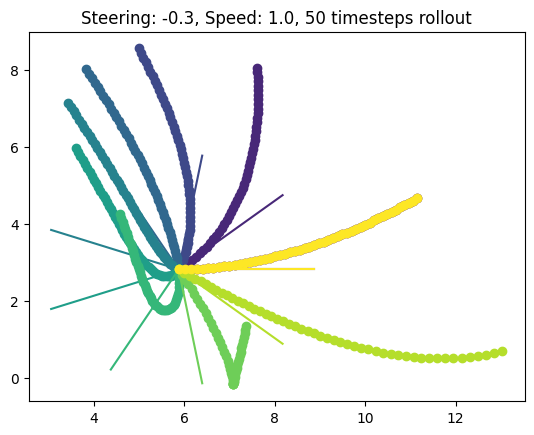

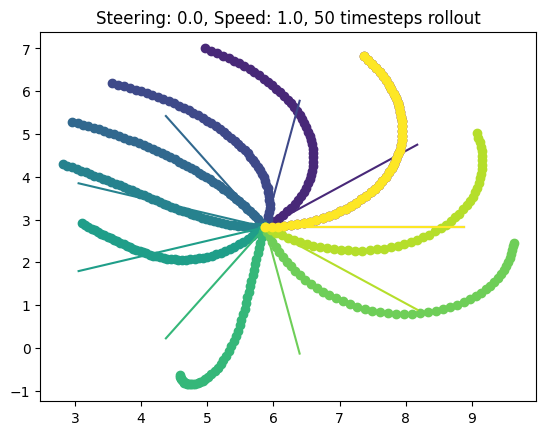

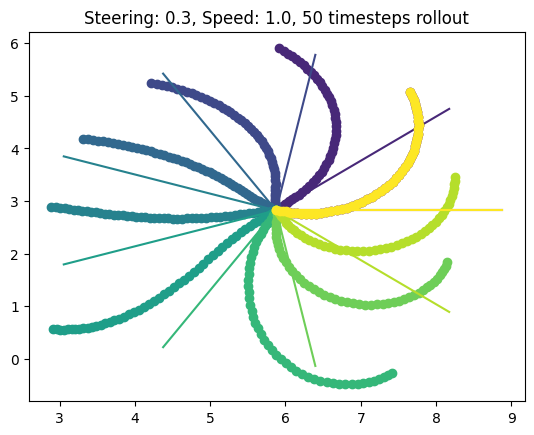

In [13]:
# fake zero state
steerings = [-0.3, 0.0, 0.3]
for j in range(3):
    
    for i in range(len(theta)):
        states = behavior_dataset.states[0]
        unnormalized_states = behavior_dataset.unnormalize_states(states)
        new_state = unnormalized_states.clone()
        new_state[-1] = 1.0 # speed is 0
        new_state[-2] = steerings[j]# steering is 0
        
        new_state[2] = theta_sin[i]
        new_state[3] = theta_cos[i]
        new_state[4] = 0.0
        new_state[5] = 0.0
        new_state[6] = 0.0
        new_state = behavior_dataset.normalize_states(new_state)

        new_state[0] = 0.0
        new_state[1] = -1.5

        
        states_, actions_ = model.rollout(new_state.unsqueeze(0).unsqueeze(0), torch.zeros((1,1,2)), get_target_action=get_target_action, horizon=50)
        # print(states_[:,:,2])
        unnormed_states = behavior_dataset.unnormalize_states(states_).squeeze(0)
        plt.plot(unnormed_states[:,0], unnormed_states[:,1], color=cmap(i))
        plt.plot(unnormed_states[:,0], unnormed_states[:,1], 'o', color=cmap(i))
    
        # draw a straight line from the start to +3 according to the angle of theta
        x_end = unnormed_states[0,0] + 3 * theta_cos[i]
        y_end = unnormed_states[0,1] + 3 * theta_sin[i]
        plt.plot([unnormed_states[0,0], x_end], [unnormed_states[0,1], y_end], 'r', color=cmap(i))
    plt.title(f"Steering: {steerings[j]}, Speed: 1.0, 50 timesteps rollout")

    plt.show()
    


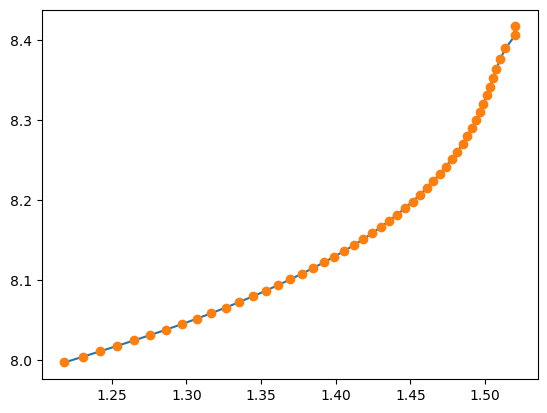

In [20]:
print(unnormed_states[:,0])

tensor([4.7684e-07, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01,
        8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01,
        8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01,
        8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01,
        8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01,
        8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01,
        8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01,
        8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01, 8.7171e-01,
        8.7171e-01, 8.7171e-01])
